# The Best Format to Save Pandas Data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import os

In [3]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import gc
from multiprocessing import Process, Event, Value
import os
import time
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import psutil


class Timer:
    """Simple util to measure execution time.
    Examples
    --------
    >>> import time
    >>> with Timer() as timer:
    ...     time.sleep(1)
    >>> print(timer)
    00:00:01
    """
    def __init__(self):
        self.start = None
        self.elapsed = None

    def __enter__(self):
        self.start = default_timer()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.elapsed = default_timer() - self.start

    def __str__(self):
        return self.verbose()

    def __float__(self):
        return self.elapsed

    def verbose(self):
        if self.elapsed is None:
            return '<not-measured>'
        return self.format_elapsed_time(self.elapsed)

    @staticmethod
    def format_elapsed_time(value: float):
        return time.strftime('%H:%M:%S', time.gmtime(value))
    
    
class MemoryTrackingProcess(Process):
    """A process that periodically measures the amount of RAM consumed by another process.
    
    This process is stopped as soon as the event is set.
    """
    def __init__(self, pid, event, **kwargs):
        super().__init__()
        self.p = psutil.Process(pid)
        self.event = event
        self.max_mem = Value('f', 0.0)
        
    def run(self):
        mem_usage = []
        while not self.event.is_set():
            info = self.p.memory_info()
            mem_bytes = info.rss
            mem_usage.append(mem_bytes)
            time.sleep(0.05)
        self.max_mem.value = np.max(mem_usage)


class MemoryTracker:
    """A context manager that runs MemoryTrackingProcess in background and collects 
    the information about used memory when the context is exited.
    """
    def __init__(self, pid=None):
        pid = pid or os.getpid()
        self.start_mem = psutil.Process(pid).memory_info().rss
        self.event = Event()
        self.p = MemoryTrackingProcess(pid, self.event)
    
    @property
    def memory(self):
        return self.p.max_mem.value - self.start_mem
    
    def __enter__(self):
        self.p.start()
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.event.set()
        self.p.join()

        
class GC:
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, ext_tb):
        self.collected = gc.collect()
        

class VisualStyle:
    def __init__(self, config, default=None):
        if default is None:
            default = plt.rcParams
        self.default = default.copy()
        self.config = config
        
    def replace(self):
        plt.rcParams = self.config
    
    def override(self, extra=None):
        plt.rcParams.update(self.config)
        if extra is not None:
            plt.rcParams.update(extra)

    def restore(self):
        plt.rcParams = self.default


class NotebookStyle(VisualStyle):
    def __init__(self):
        super().__init__({
            'figure.figsize': (11, 8),
            'axes.titlesize': 20,
            'axes.labelsize': 18,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14,
            'font.size': 16
        })

In [5]:
style = NotebookStyle()
style.override({'grid.color': 'lightgray'})

## Random Dataset

In [6]:
def generate_dataset(n_rows, num_count, cat_count, max_nan=0.1, max_cat_size=100):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    The categorical features are generated as random uuid4 strings with 
    cardinality C where 2 <= C <= max_cat_size.
    
    Also, a max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    def generate_categories():
        # from uuid import uuid4
        category_size = np.random.randint(2, max_cat_size)
        data_strings = pd.util.testing.rands_array(36, size=category_size)
        return data_strings
        # return [str(uuid4()) for _ in range(category_size)]
    
    for col in range(num_count):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        # values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
        
    for col in range(cat_count):
        name = f'c{col}'
        cats = generate_categories()
        values = np.array(np.random.choice(cats, n_rows, replace=True), dtype=object)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        # values[index] = np.nan
        dataset[name] = values
        types[name] = 'object'
    
    return pd.DataFrame(dataset), types

## Benchmarking

In [7]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [8]:
from uuid import uuid4
len(str(uuid4()))

36

In [10]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [11]:
def benchmark(list_of_formats, data_size=1_000_000, n_num=15, n_cat=15, n_rounds=5,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...')
        dataset, _ = generate_dataset(data_size, n_num, n_cat)
        
        if as_category:
            print('\tconverting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        benchmark = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print('\ttesting format:', fmt)
                filename = f'random.{fmt}'
                save, load = get_save_load(dataset, fmt)
                results = defaultdict(int)
                results['format'] = fmt
                results['filename'] = filename
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        save(filename, **params)
                results['size_mb'] = size_of(filename)
                results['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['save_time'] = float(timer)
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        _ = load(filename)
                results['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['load_time'] = float(timer)
                
                benchmark.append(results)
                
            run = pd.DataFrame(benchmark)
            run['run_no'] = i
            runs.append(run)
            
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark

### CSV Baseline

In [13]:
formats = [('csv', {'index': None})]

In [14]:
csv_results = benchmark(formats, n_rounds=2)

Benchmarking round #1
	generating dataset...


/usr/local/lib/python3.7/dist-packages/pandas/util/__init__.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing


	testing format: csv
Benchmarking round #2
	generating dataset...
	testing format: csv


In [15]:
csv_results.to_feather('baseline.feather')

In [16]:
baseline = feather.read_dataframe('baseline.feather')

In [17]:
baseline

,format,filename,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time,run_no
0,csv,random.csv,810.12,5.121094,40.035170,437.367188,12.663160,0
1,csv,random.csv,810.12,1.347656,46.521314,371.980469,12.242904,1


### Categoricals As Strings

In [18]:
formats = [
    ('hdf', {'key': 'data', 'mode':'w',  'complevel':5, 'complib':'blosc:lz4'}),
    ('pickle',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [19]:
results = benchmark(formats, n_rounds=2)

Benchmarking round #1
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet


In [20]:
results.to_feather('one_million_cats_str.feather')

In [21]:
results = feather.read_dataframe('one_million_cats_str.feather')

In [22]:
results = pd.concat([baseline, results], axis=0, sort=False)

In [23]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,810.120,3.234375,43.278242,404.673828,12.453032
1,feather,229.560,717.478516,1.653951,634.095703,1.078756
2,hdf,163.125,4.697266,1.900710,123.738281,2.068860
3,parquet,128.775,488.107422,2.444796,813.865234,1.498696
4,pickle,176.825,-0.001953,1.089862,43.875000,1.088745


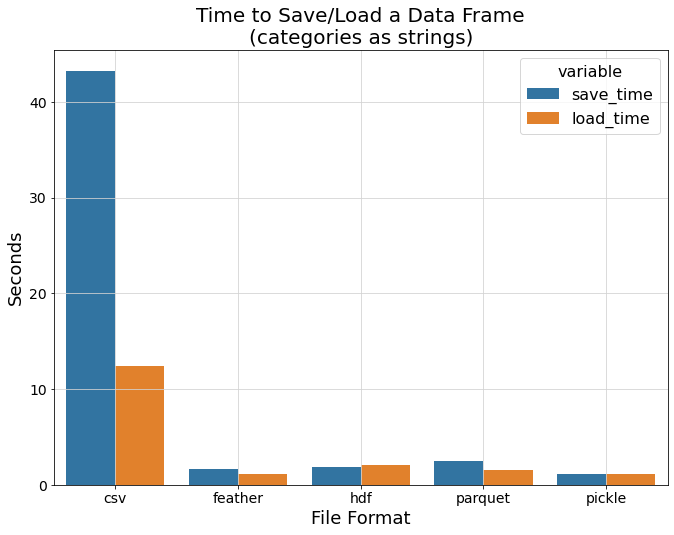

In [24]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)

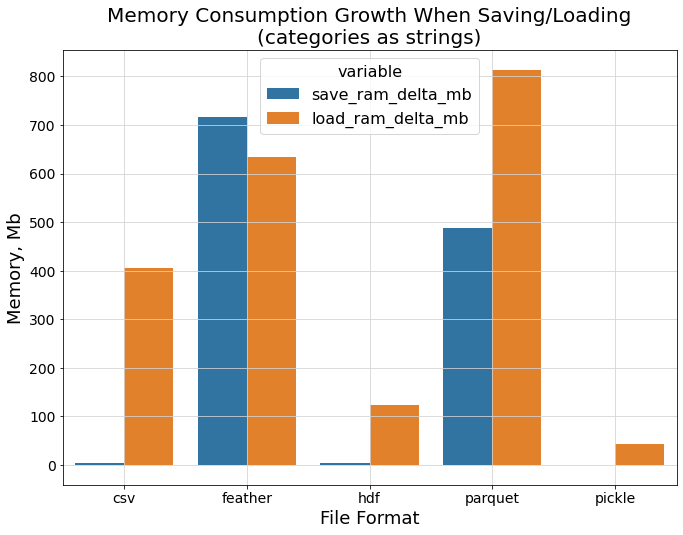

In [25]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as strings)')
ax.grid(True)

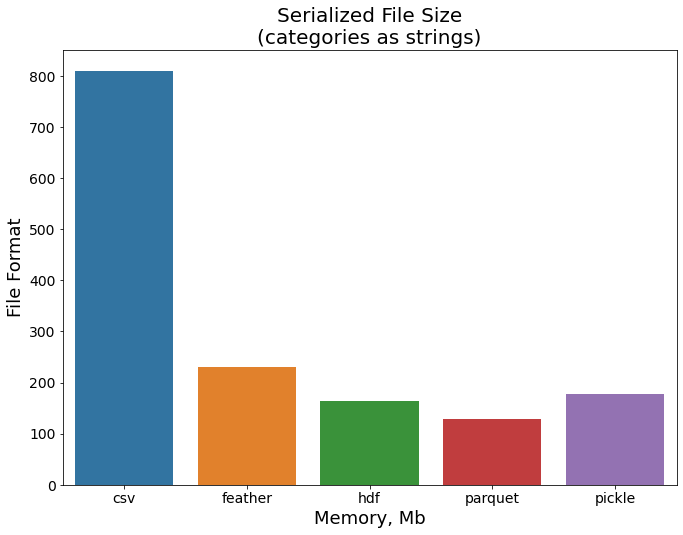

In [26]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as strings)')

### Categoricals As Dedicated Category Type

In [30]:
formats = [
    ('hdf', {'key': 'data', 'mode':'w',  'complevel':5, 'complib':'blosc:lz4', 'format':'table'}),
    ('pickle',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [32]:
results = benchmark(formats, as_category=True, n_rounds=2)

Benchmarking round #1
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet


In [33]:
results.to_feather('one_million_cats_category.feather')

In [34]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [35]:
results = pd.concat([baseline, results], axis=0)

In [36]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,810.12,3.234375,43.278242,404.673828,12.453032
1,feather,128.28,16.519531,0.414854,243.468750,0.282968
2,hdf,123.25,0.283203,2.190795,-0.019531,1.400375
3,parquet,129.14,28.671875,1.030294,390.824219,0.584644
4,pickle,128.78,-0.023438,0.286576,-0.023438,0.234592


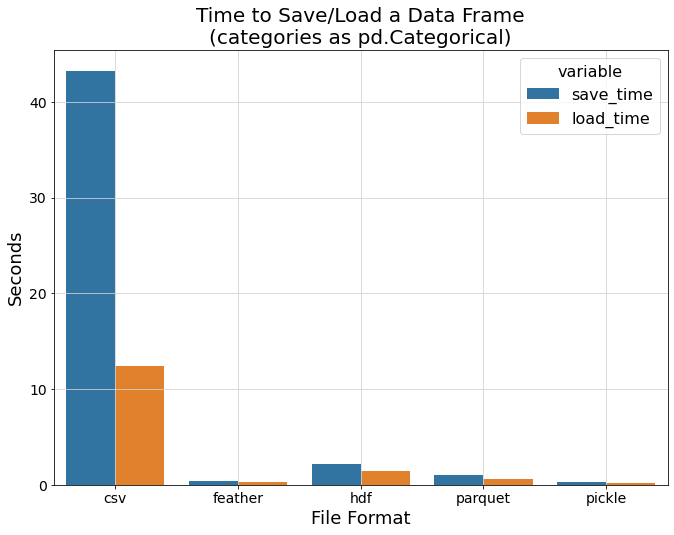

In [37]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

In [38]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [39]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])

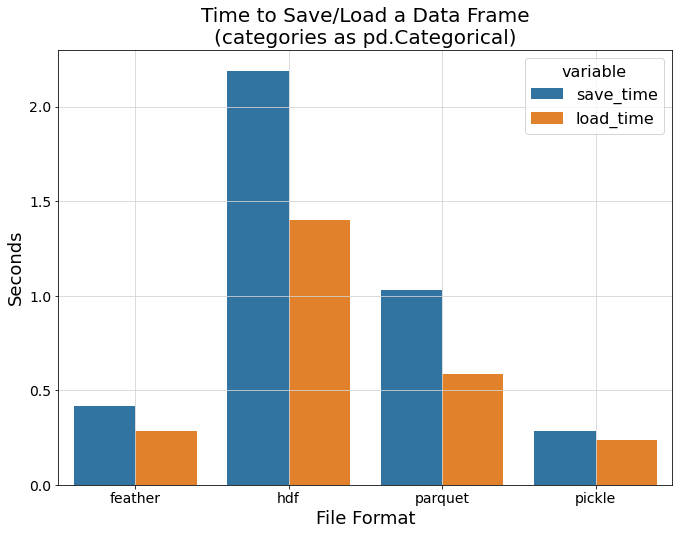

In [40]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

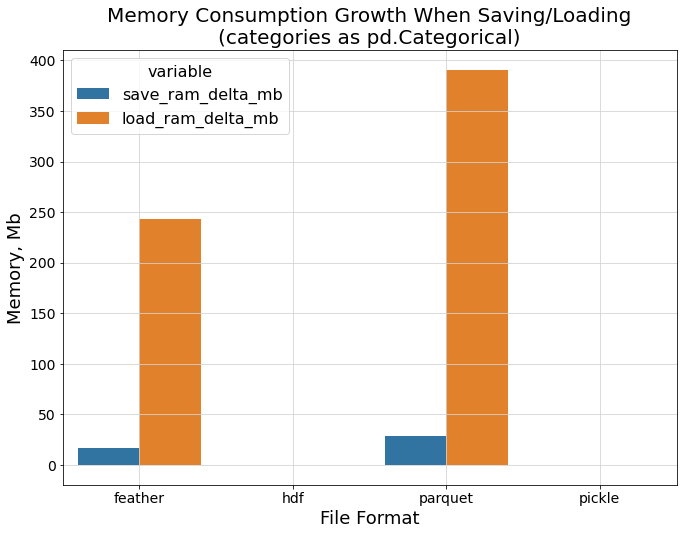

In [41]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as pd.Categorical)')
ax.grid(True)

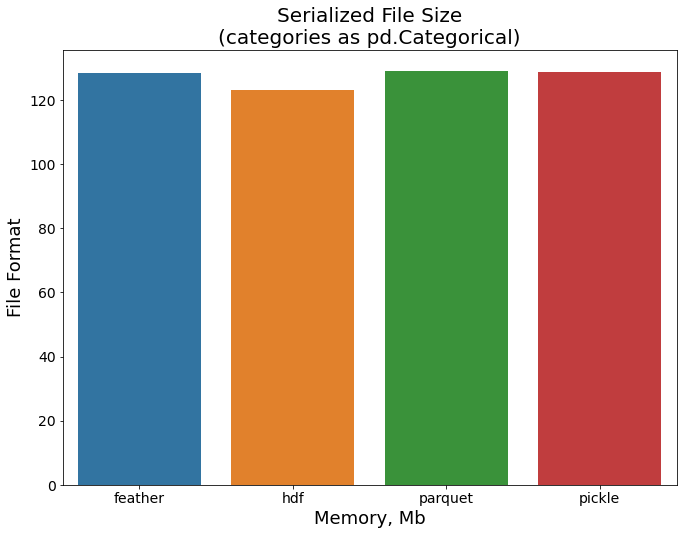

In [42]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as pd.Categorical)')